In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import mutagenesis_functions as mf
import time as time

In [3]:
# load hairpin data
data_path = 'data_peter/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [8]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    layer4 = {'layer': 'conv1d',
            'num_filters': 196,
            'filter_size': 3,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5,
            'padding': 'VALID',
            }
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = 'results/trial_peter'
param_path = os.path.join(save_path, 'hairpin_steffan')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [9]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 196)
layer17: conv1d_1_batch
(?, 1, 1, 196)
layer18: conv1d_1_active
(?, 1, 1, 196)
layer19: conv1d_1_dropout


In [10]:
# initialize session
sess = utils.initialize_session()

In [27]:

# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, batch_size=100, num_epochs=200,
                    patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 200 
[==============================] 100.0% -- elapsed time=19.47s -- loss=0.29552 -- acc=86.55417%  
 
  valid loss:		0.10747
  valid accuracy:	0.96135+/-0.00000
  valid auc-roc:	0.99414+/-0.00000
  valid auc-pr:		0.98418+/-0.00000
  lower cross-validation found
  saving model to:  ../results/trial/hairpin_steffan_best.ckpt
Epoch 2 out of 200 
[==============================] 100.0% -- elapsed time=19.17s -- loss=0.17462 -- acc=93.37813%  
 
  valid loss:		0.10216
  valid accuracy:	0.96279+/-0.00000
  valid auc-roc:	0.99585+/-0.00000
  valid auc-pr:		0.98814+/-0.00000
  lower cross-validation found
  saving model to:  ../results/trial/hairpin_steffan_best.ckpt
Epoch 3 out of 200 
[==============================] 100.0% -- elapsed time=18.91s -- loss=0.15808 -- acc=94.21719%  
 
  valid loss:		0.10079
  valid accuracy:	0.96383+/-0.00000
  valid auc-roc:	0.99600+/-0.00000
  valid auc-pr:		0.98809+/-0.00000
  lower cross-validation found
  saving model to:  ../results/tri

[==============================] 100.0% -- elapsed time=19.80s -- loss=0.07720 -- acc=98.27136%  
 
  valid loss:		0.05012
  valid accuracy:	0.99110+/-0.00000
  valid auc-roc:	0.99962+/-0.00000
  valid auc-pr:		0.99853+/-0.00000
Epoch 59 out of 200 
[==============================] 100.0% -- elapsed time=19.97s -- loss=0.07502 -- acc=98.29323%  
 
  valid loss:		0.04863
  valid accuracy:	0.99162+/-0.00000
  valid auc-roc:	0.99955+/-0.00000
  valid auc-pr:		0.99834+/-0.00000
Epoch 60 out of 200 
[==============================] 100.0% -- elapsed time=20.00s -- loss=0.07471 -- acc=98.30833%  
 
  valid loss:		0.04749
  valid accuracy:	0.99173+/-0.00000
  valid auc-roc:	0.99956+/-0.00000
  valid auc-pr:		0.99844+/-0.00000
  lower cross-validation found
  saving model to:  ../results/trial/hairpin_steffan_best.ckpt
Epoch 61 out of 200 
[==============================] 100.0% -- elapsed time=19.96s -- loss=0.07574 -- acc=98.32136%  
 
  valid loss:		0.04844
  valid accuracy:	0.99162+/-0.000

Epoch 89 out of 200 
[==============================] 100.0% -- elapsed time=19.84s -- loss=0.06975 -- acc=98.45677%  
 
  valid loss:		0.04855
  valid accuracy:	0.99146+/-0.00000
  valid auc-roc:	0.99955+/-0.00000
  valid auc-pr:		0.99870+/-0.00000
Epoch 90 out of 200 
[==============================] 100.0% -- elapsed time=19.95s -- loss=0.07073 -- acc=98.44479%  
 
  valid loss:		0.04571
  valid accuracy:	0.99250+/-0.00000
  valid auc-roc:	0.99963+/-0.00000
  valid auc-pr:		0.99900+/-0.00000
Epoch 91 out of 200 
[==============================] 100.0% -- elapsed time=19.86s -- loss=0.06860 -- acc=98.52240%  
 
  valid loss:		0.04656
  valid accuracy:	0.99217+/-0.00000
  valid auc-roc:	0.99955+/-0.00000
  valid auc-pr:		0.99876+/-0.00000
Epoch 92 out of 200 
[==============================] 100.0% -- elapsed time=20.25s -- loss=0.07111 -- acc=98.43438%  
 
  valid loss:		0.04513
  valid accuracy:	0.99262+/-0.00000
  valid auc-roc:	0.99958+/-0.00000
  valid auc-pr:		0.99878+/-0.00000


KeyboardInterrupt: 

In [11]:
# set best parameters
nntrainer.set_best_parameters(sess)

#Get Predictions

# calculate activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
predictionslogits = nntrainer.get_activations(sess, test, layer='dense_0_bias')

loading model from:  results/trial_peter/hairpin_steffan_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial_peter/hairpin_steffan_best.ckpt


# Average the second order mutagenesis scores for 1000 different sequences

Since each mutagenesis produces 41*41*16 = 26896 sequences, getting scores for 1000 is gonna take a long time...

In [12]:
# sort activations
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

In [30]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_summary = 100

sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()
    


loading model from:  ../results/trial/hairpin_steffan_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/trial/hairpin_steffan_best.ckpt
0
Epoch duration =0.39s
Cumulative duration =0.39s

1
Epoch duration =0.32s
Cumulative duration =0.71s

2
Epoch duration =0.33s
Cumulative duration =1.05s

3
Epoch duration =0.32s
Cumulative duration =1.37s

4
Epoch duration =0.32s
Cumulative duration =1.69s

5
Epoch duration =0.32s
Cumulative duration =2.01s

6
Epoch duration =0.32s
Cumulative duration =2.34s

7
Epoch duration =0.33s
Cumulative duration =2.67s

8
Epoch duration =0.32s
Cumulative duration =3.0s

9
Epoch duration =0.32s
Cumulative duration =3.32s

10
Epoch duration =0.33s
Cumulative duration =3.65s

11
Epoch duration =0.32s
Cumulative duration =3.97s

12
Epoch duration =0.32s
Cumulative duration =4.29s

13
Epoch duration =0.31s
Cumulative duration =4.6s

14
Epoch duration =0.32s
Cumulative duration =4.92s

15
Epoch duration =0.32s
Cumulative duration =5.24s

16
Epoch durati

In [31]:

#num_summary = 100

#sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(100,1000):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()
    


100
Epoch duration =0.31s
Cumulative duration =0.31s

101
Epoch duration =0.32s
Cumulative duration =0.63s

102
Epoch duration =0.33s
Cumulative duration =0.96s

103
Epoch duration =0.32s
Cumulative duration =1.28s

104
Epoch duration =0.32s
Cumulative duration =1.61s

105
Epoch duration =0.32s
Cumulative duration =1.93s

106
Epoch duration =0.33s
Cumulative duration =2.26s

107
Epoch duration =0.34s
Cumulative duration =2.6s

108
Epoch duration =0.32s
Cumulative duration =2.91s

109
Epoch duration =0.32s
Cumulative duration =3.23s

110
Epoch duration =0.32s
Cumulative duration =3.56s

111
Epoch duration =0.33s
Cumulative duration =3.89s

112
Epoch duration =0.33s
Cumulative duration =4.21s

113
Epoch duration =0.32s
Cumulative duration =4.53s

114
Epoch duration =0.32s
Cumulative duration =4.85s

115
Epoch duration =0.33s
Cumulative duration =5.18s

116
Epoch duration =0.34s
Cumulative duration =5.52s

117
Epoch duration =0.33s
Cumulative duration =5.84s

118
Epoch duration =0.34s
Cum

Epoch duration =0.33s
Cumulative duration =49.45s

251
Epoch duration =0.33s
Cumulative duration =49.78s

252
Epoch duration =0.32s
Cumulative duration =50.1s

253
Epoch duration =0.33s
Cumulative duration =50.43s

254
Epoch duration =0.34s
Cumulative duration =50.77s

255
Epoch duration =0.35s
Cumulative duration =51.11s

256
Epoch duration =0.33s
Cumulative duration =51.45s

257
Epoch duration =0.32s
Cumulative duration =51.77s

258
Epoch duration =0.33s
Cumulative duration =52.1s

259
Epoch duration =0.33s
Cumulative duration =52.42s

260
Epoch duration =0.33s
Cumulative duration =52.75s

261
Epoch duration =0.35s
Cumulative duration =53.1s

262
Epoch duration =0.33s
Cumulative duration =53.43s

263
Epoch duration =0.34s
Cumulative duration =53.76s

264
Epoch duration =0.33s
Cumulative duration =54.1s

265
Epoch duration =0.32s
Cumulative duration =54.42s

266
Epoch duration =0.34s
Cumulative duration =54.76s

267
Epoch duration =0.32s
Cumulative duration =55.08s

268
Epoch duration

Epoch duration =0.33s
Cumulative duration =99.01s

401
Epoch duration =0.33s
Cumulative duration =99.34s

402
Epoch duration =0.33s
Cumulative duration =99.67s

403
Epoch duration =0.32s
Cumulative duration =100.0s

404
Epoch duration =0.33s
Cumulative duration =100.33s

405
Epoch duration =0.32s
Cumulative duration =100.65s

406
Epoch duration =0.33s
Cumulative duration =100.98s

407
Epoch duration =0.32s
Cumulative duration =101.3s

408
Epoch duration =0.33s
Cumulative duration =101.63s

409
Epoch duration =0.33s
Cumulative duration =101.97s

410
Epoch duration =0.32s
Cumulative duration =102.29s

411
Epoch duration =0.33s
Cumulative duration =102.61s

412
Epoch duration =0.33s
Cumulative duration =102.94s

413
Epoch duration =0.34s
Cumulative duration =103.29s

414
Epoch duration =0.34s
Cumulative duration =103.63s

415
Epoch duration =0.33s
Cumulative duration =103.96s

416
Epoch duration =0.32s
Cumulative duration =104.28s

417
Epoch duration =0.33s
Cumulative duration =104.6s

41

Epoch duration =0.33s
Cumulative duration =147.54s

548
Epoch duration =0.33s
Cumulative duration =147.87s

549
Epoch duration =0.33s
Cumulative duration =148.2s

550
Epoch duration =0.33s
Cumulative duration =148.53s

551
Epoch duration =0.32s
Cumulative duration =148.85s

552
Epoch duration =0.33s
Cumulative duration =149.18s

553
Epoch duration =0.33s
Cumulative duration =149.51s

554
Epoch duration =0.34s
Cumulative duration =149.85s

555
Epoch duration =0.33s
Cumulative duration =150.18s

556
Epoch duration =0.34s
Cumulative duration =150.52s

557
Epoch duration =0.32s
Cumulative duration =150.84s

558
Epoch duration =0.34s
Cumulative duration =151.18s

559
Epoch duration =0.33s
Cumulative duration =151.51s

560
Epoch duration =0.33s
Cumulative duration =151.84s

561
Epoch duration =0.33s
Cumulative duration =152.17s

562
Epoch duration =0.34s
Cumulative duration =152.51s

563
Epoch duration =0.33s
Cumulative duration =152.85s

564
Epoch duration =0.33s
Cumulative duration =153.18

Epoch duration =0.5s
Cumulative duration =196.4s

695
Epoch duration =0.5s
Cumulative duration =196.89s

696
Epoch duration =0.5s
Cumulative duration =197.4s

697
Epoch duration =0.51s
Cumulative duration =197.91s

698
Epoch duration =0.47s
Cumulative duration =198.39s

699
Epoch duration =0.53s
Cumulative duration =198.92s

700
Epoch duration =0.47s
Cumulative duration =199.39s

701
Epoch duration =0.48s
Cumulative duration =199.87s

702
Epoch duration =0.49s
Cumulative duration =200.36s

703
Epoch duration =0.5s
Cumulative duration =200.86s

704
Epoch duration =0.54s
Cumulative duration =201.4s

705
Epoch duration =0.51s
Cumulative duration =201.9s

706
Epoch duration =0.49s
Cumulative duration =202.39s

707
Epoch duration =0.5s
Cumulative duration =202.89s

708
Epoch duration =0.49s
Cumulative duration =203.38s

709
Epoch duration =0.51s
Cumulative duration =203.89s

710
Epoch duration =0.53s
Cumulative duration =204.42s

711
Epoch duration =0.47s
Cumulative duration =204.89s

712
E

Epoch duration =0.32s
Cumulative duration =250.56s

842
Epoch duration =0.32s
Cumulative duration =250.88s

843
Epoch duration =0.33s
Cumulative duration =251.22s

844
Epoch duration =0.32s
Cumulative duration =251.54s

845
Epoch duration =0.32s
Cumulative duration =251.86s

846
Epoch duration =0.33s
Cumulative duration =252.2s

847
Epoch duration =0.34s
Cumulative duration =252.53s

848
Epoch duration =0.33s
Cumulative duration =252.86s

849
Epoch duration =0.34s
Cumulative duration =253.2s

850
Epoch duration =0.32s
Cumulative duration =253.52s

851
Epoch duration =0.32s
Cumulative duration =253.85s

852
Epoch duration =0.32s
Cumulative duration =254.17s

853
Epoch duration =0.34s
Cumulative duration =254.51s

854
Epoch duration =0.32s
Cumulative duration =254.83s

855
Epoch duration =0.33s
Cumulative duration =255.16s

856
Epoch duration =0.32s
Cumulative duration =255.48s

857
Epoch duration =0.33s
Cumulative duration =255.81s

858
Epoch duration =0.33s
Cumulative duration =256.14s

Epoch duration =0.32s
Cumulative duration =298.73s

989
Epoch duration =0.35s
Cumulative duration =299.08s

990
Epoch duration =0.32s
Cumulative duration =299.4s

991
Epoch duration =0.33s
Cumulative duration =299.73s

992
Epoch duration =0.33s
Cumulative duration =300.07s

993
Epoch duration =0.32s
Cumulative duration =300.39s

994
Epoch duration =0.33s
Cumulative duration =300.72s

995
Epoch duration =0.33s
Cumulative duration =301.05s

996
Epoch duration =0.33s
Cumulative duration =301.38s

997
Epoch duration =0.32s
Cumulative duration =301.7s

998
Epoch duration =0.33s
Cumulative duration =302.03s

999
Epoch duration =0.34s
Cumulative duration =302.37s



In [32]:
mean_mut2_predictoutputs = sum_mut2_predictoutputs/1000

In [33]:
#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

In [34]:
#save the summed mutations data to a file
npy_save_path = 'sum_mut2_predictoutputs1000.npy'
np.save(npy_save_path, sum_mut2_predictoutputs)

In [16]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)

loading model from:  results/trial_peter/hairpin_steffan_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial_peter/hairpin_steffan_best.ckpt


In [17]:
#Load the summed mutations
sum_mut2_predictoutputs = np.load('sum_mut2_predictoutputs1000_peter.npy')
mean_mut2_predictoutputs = sum_mut2_predictoutputs/1000

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

### Signatures

###### Based pairs

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


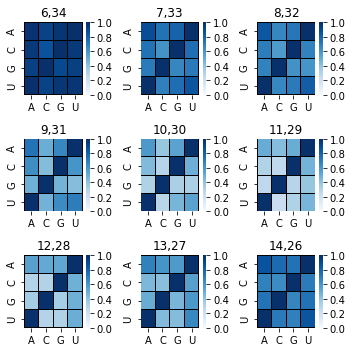

In [18]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(5,5))

num = 9

for ii in range(9):
    ax = fig4.add_subplot(3,3,ii+1)
    ax.set_title(str(6+ii)+','+str(34-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[6+ii, 34-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



In [35]:
nine_mean = np.zeros(X[0, 31].shape)

for ii in range(1000):
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    nine_mean += X[0, 31]

In [36]:
nine_mean/1000

array([[ 0.188,  0.171,  0.336,  0.305]])

###### First 20

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


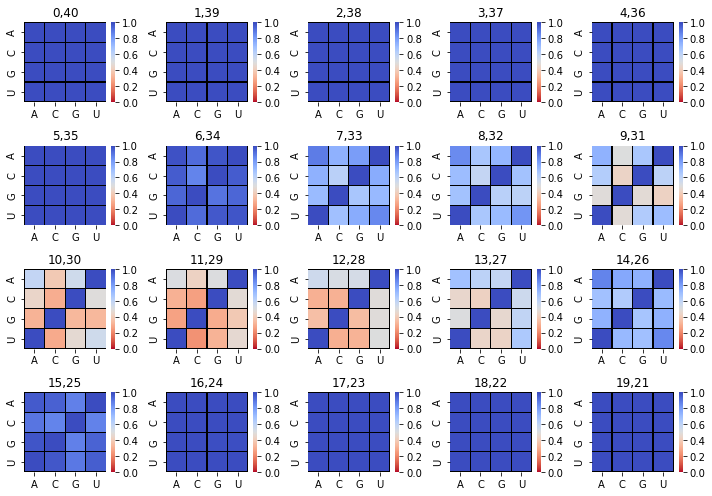

In [28]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(10,7))

num = 20

for ii in range(num):
    ax = fig4.add_subplot(4,5,ii+1)
    ax.set_title(str(ii)+','+str(40-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii, 40-ii], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)




###### All base Paired

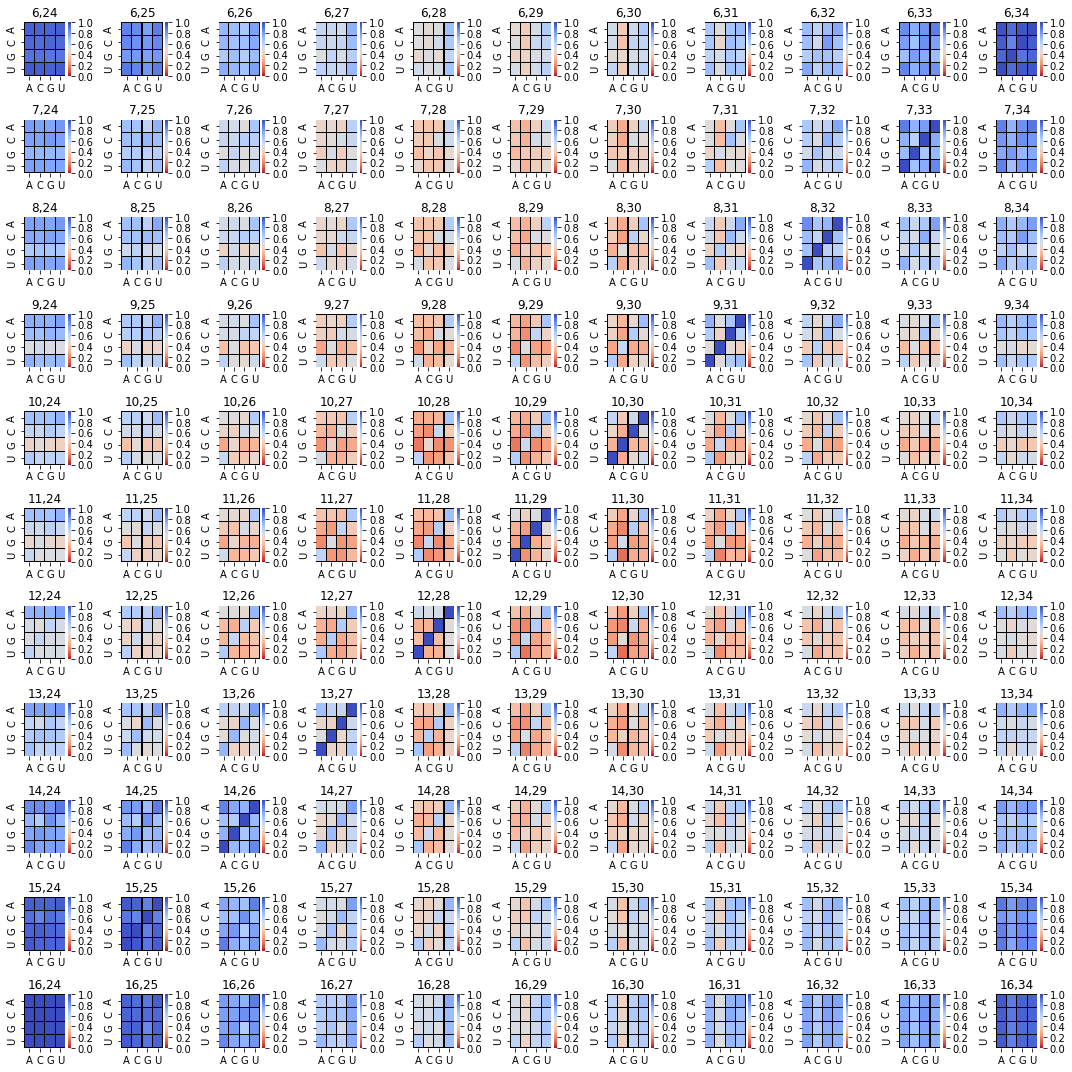

In [42]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,15))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        ax.set_title(str(one+6)+','+str(two+24))
        ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


        

###### All base Paired (editted visuals)

In [38]:
two+24

34

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


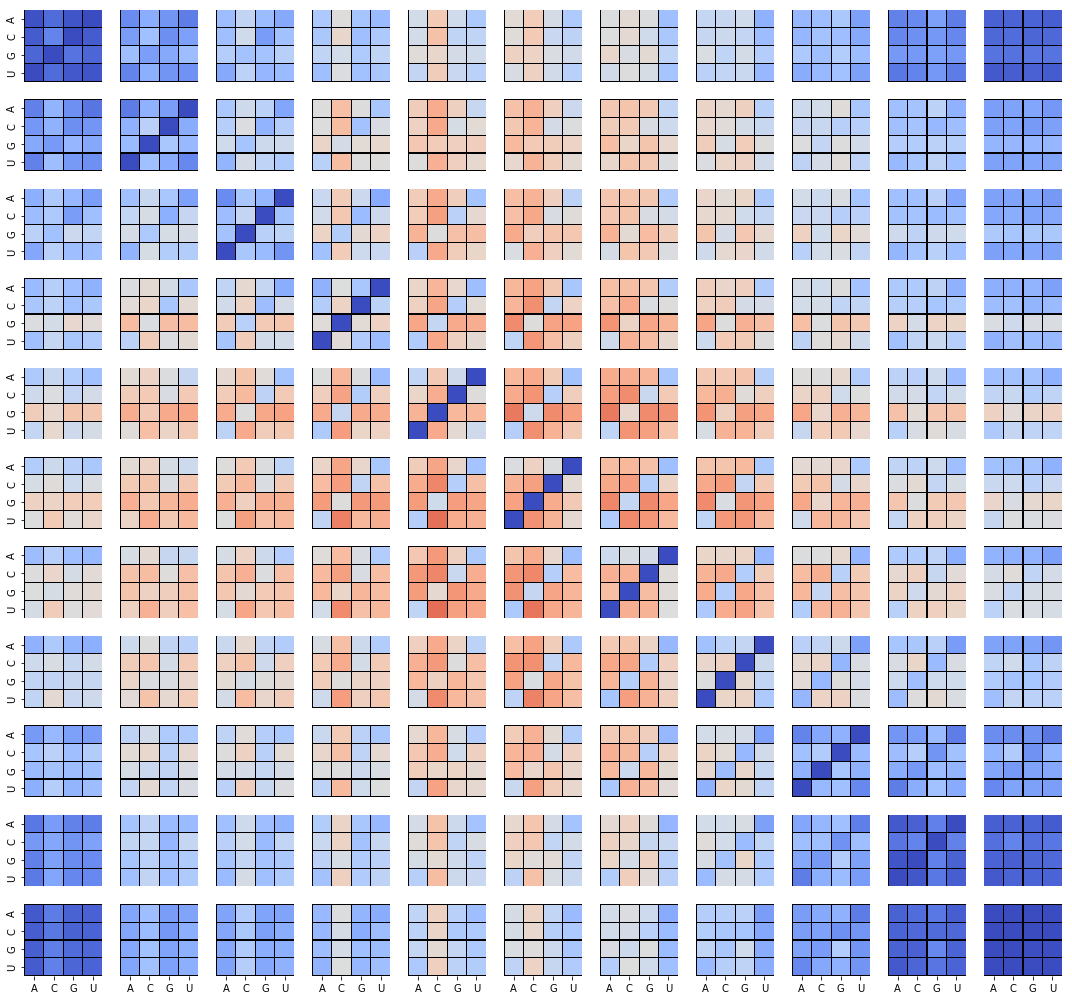

In [25]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, 34-two], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, 34-two], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, 34-two], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, 34-two], vmin=0., vmax=1., cmap='coolwarm_r', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)




        

###### Single Pair

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


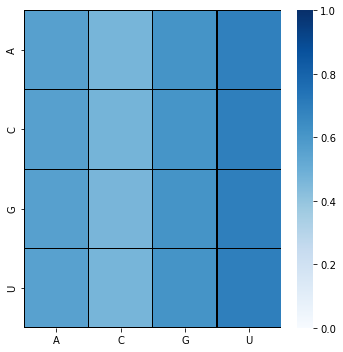

In [24]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(5,5))

ii1 = 4
ii2 = 29
ax.set_title(str(ii1)+','+str(ii2))
ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii1, ii2], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


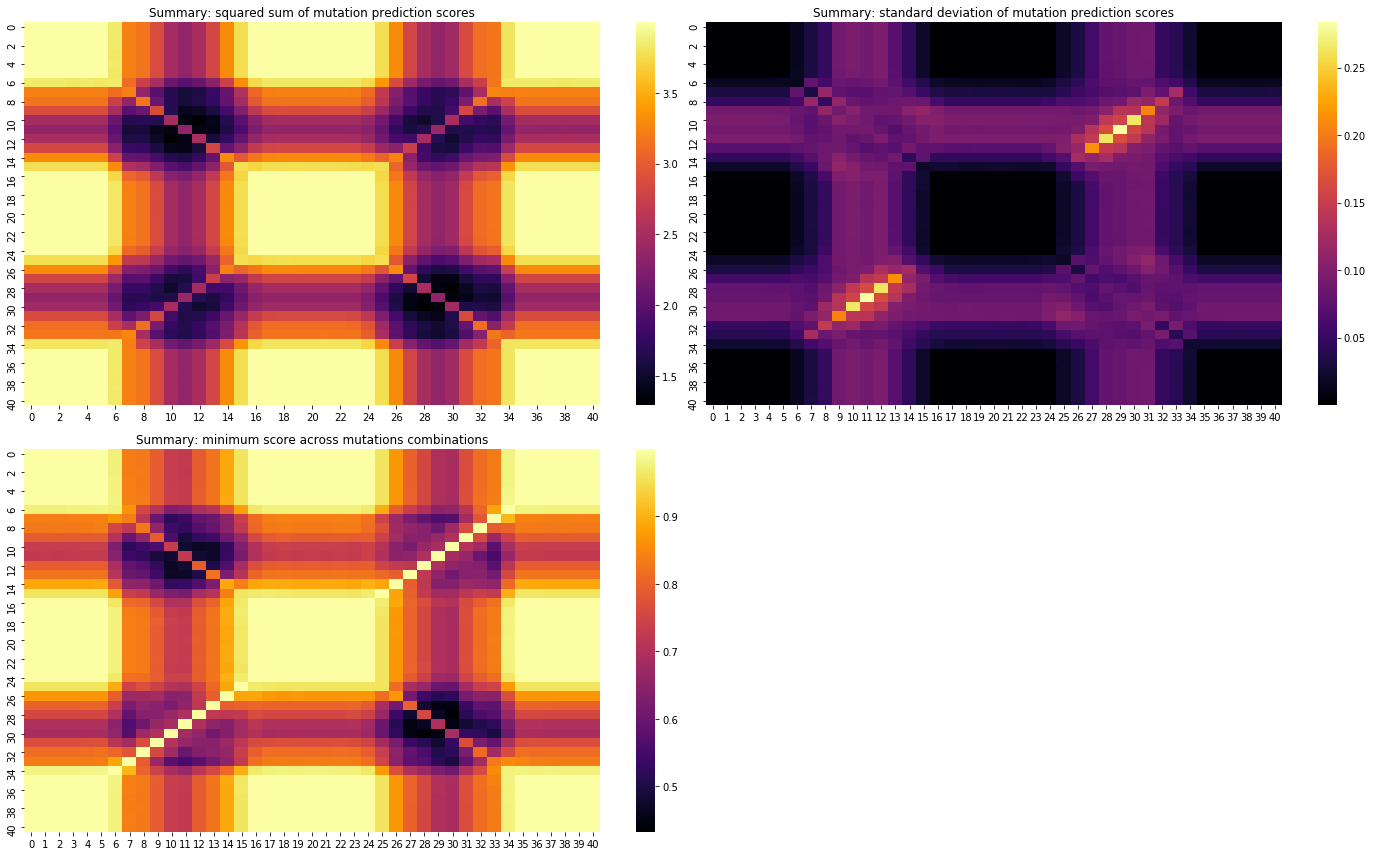

In [41]:
#Perform some sort of summary along the dims axis to plot in a heatmap

mut2_predictoutputs = mean_mut2_predictoutputs 

#Reshape into its organization L*L*mutations
mut2_predictoutputs = mut2_predictoutputs.reshape(X.shape[1],X.shape[1],16)

#Summarize the data in some way
mut2_sumoutputs = np.sqrt(np.sum(mut2_predictoutputs**2, axis=2))
mut2_stdoutputs = np.std(mut2_predictoutputs, axis=2)
mut2_maxoutputs = np.max(mut2_predictoutputs, axis=2)


#Plot heatmaps of the data
plt.figure(figsize=(20,12))

#Plot all of the data
zoom1 = 0
zoom2 = X.shape[1]

plt.subplot(221)
plt.title('Summary: squared sum of mutation prediction scores')
sb.heatmap(mut2_sumoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(222)
plt.title('Summary: standard deviation of mutation prediction scores')
sb.heatmap(mut2_stdoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(223)
plt.title('Summary: minimum score across mutations combinations')
sb.heatmap(mut2_maxoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')